# Methdods: Data Analysis

In this document, I aim to make reproduction of our results as easy as possible. All data is stored in and downloaded from [our main Spreadsheet](https://docs.google.com/spreadsheets/d/1eIdupjcWapVGPNMNTeKbnaPIroOXP6taFhrDMn5z3D4/edit?usp=sharing), but you can also change this part to ingest any files or else. Once all the data is successfully loaded, all calculations and figure generation should be fully automatic. Please notify constantin.goeldel@tum.de if you come across any issues.

To replicate our results, optain the datasets, then run all the cells. The data in the spreadsheet is just the content of the results.txt file you will get when running the metaprofile application.

In [4]:
# Link to the datsets
!wget https://syncandshare.lrz.de/dl/fiGJnLiRVUR4q5ijx7vgd8/methylomes.tar.gz
!tar -xzf methylomes.tar.gz

--2023-06-30 11:37:32--  https://syncandshare.lrz.de/dl/fiGJnLiRVUR4q5ijx7vgd8/methylomes.tar.gz
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10653453799 (9.9G) [application/x-gzip]
Saving to: ‘methylomes.tar.gz’

methylomes.tar.gz     0%[                    ]   6.73M   620KB/s    eta 5h 14m ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [149]:
# Install Rust (shown for Linux/WSL otherwise see https://www.rust-lang.org/tools/install)
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

# Install the alphabeta & metaprofile binaries 
!cargo install alphabeta

# WT
!metaprofile \
-m ./methylomes/wt/MA3_new_total_original_methylome/ \
-g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
-o ./methylomes/wt \
--name wildtype \
-s 1 -w 5 \ 
alphabeta \
-e ./wt_edgelist.txt \
-n ./wt_nodelist.txt 


# CMT3
!metaprofile \
-m ./methylomes/cmt3/total_original_methylome \
-g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
-o ./methylomes/cmt3 \
--name cmt3 \
-s 1 -w 5 \
alphabeta \
-e ./cmt3_edgelist.txt \
-n ./cmt3_nodelist.txt 

#suv 4/5/6
!metaprofile \
-m ./methylomes/suv/total_original_methylome \
-g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
-o ./methylomes/suv \
--name suv \
-s 1 -w 5 \
alphabeta \
-e ./SUV456_edgelist.txt \
-n ./SUV456_nodelist.txt 

SyntaxError: invalid syntax (3752383294.py, line 2)

In [1]:
%pip install gspread oauth2client numpy matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Connect to Google Sheets API

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# authorize the API client with the credentials
client = gspread.oauth()

# open the Google Sheets document by its URL or ID
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1eIdupjcWapVGPNMNTeKbnaPIroOXP6taFhrDMn5z3D4/edit#gid=1888658763')
# alternatively, you can open by the sheet ID only: client.open_by_key('your_sheet_id')

# get the worksheet by its name or index
worksheet = sheet.worksheet('2023_01_13_relative_5_1')
# alternatively, you can get by index: sheet.get_worksheet(0)

# fetch the data from the worksheet as a list of lists
data = worksheet.get_all_values()

mods = sheet.worksheet("Mods").get_all_values()

bivariate_raw = sheet.worksheet("Bivariate Analysis").get_all_values()

cmt3raw = sheet.worksheet("CMT3 Confirmation").get_all_values()
suvraw = sheet.worksheet("SUV Confirmation").get_all_values() 
wt_new_raw = sheet.worksheet("WT Confirmation").get_all_values()

D_dt_raw = sheet.worksheet("D_dt").get_all_values()

meth_lvl_raw = sheet.worksheet("meth_lvl").get_all_values()

Load data into numpy arrays

In [17]:
import numpy as np


headers, wt_pre = data[0], data[1:]
mods_headers, mod_pre = mods[0], mods[1:]
cmt3_headers, cmt3_pre = cmt3raw[0], cmt3raw[1:]
suv_headers, suv_pre = suvraw[0], suvraw[1:]
bivariate_headers, bivariate_pre = bivariate_raw[0], bivariate_raw[1:]
D_dt_headers, D_dt_pre = D_dt_raw[0], D_dt_raw[1:]
wt_new_headers, wt_new_pre = wt_new_raw[0], wt_new_raw[1:]


wt = np.array(wt_pre, dtype=np.float32)
mod = np.array(mod_pre, dtype=np.float32)
cmt3 = np.array(cmt3_pre, dtype=np.float32)
suv = np.array(suv_pre, dtype=np.float32)
bivariate = np.array(bivariate_pre, dtype=np.float32)
D_dt = np.array(D_dt_pre, dtype=np.float32)
wt_new = np.array(wt_new_pre, dtype=np.float32)
meth_lvl = [ meth_lvl_raw[i+1][7] for i in range(8)]

u = [i for i in range(-500, 0, 5)]
g=  [i for i in range(0, 1000, 10)]
d = [i for i in range(1000, 1500, 5)]

x = u + g + d


obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
pred = wt_new[:, wt_new_headers.index('pred_steady_state')]
alpha = wt_new[:, wt_new_headers.index('alpha')]
beta = wt_new[:, wt_new_headers.index('beta')]
alpha_ci_lower = wt_new[:, wt_new_headers.index("ci_alpha_0.025")]
alpha_ci_upper = wt_new[:, wt_new_headers.index("ci_alpha_0.975")]
beta_ci_lower = wt_new[:, wt_new_headers.index("ci_beta_0.025")]
beta_ci_upper = wt_new[:, wt_new_headers.index("ci_beta_0.975")]
cg_int = bivariate[:, bivariate_headers.index('CG Density')]
cg_density = cg_int * 100  / (3955 * 5314 * 14) # Division into 100 windows, Average gene length 3955 bp, Number of genes 5314, 14 separate WGBS samples
h2az = bivariate[:, bivariate_headers.index('H2AZ')]  / (5314 * 14)
# h2az_compressed = [sum(h2az[i:i+10]) for i in range(0, len(h2az), 10)]

In [18]:
from matplotlib import pyplot as plt
# from matplotlib import font_manager

# # font_path = font_manager.findfont('Calibri')
# # plt.rcParams.update({'font.family': 'Calibri',
# #                      'font.size': 12})

## Fig. 3
- A: Observed vs predicted steady state methylation in in WT
- B: Alpha and Beta in WT
- C: CG density & H2AZ in WT

All above each other, connected TSS and TTS


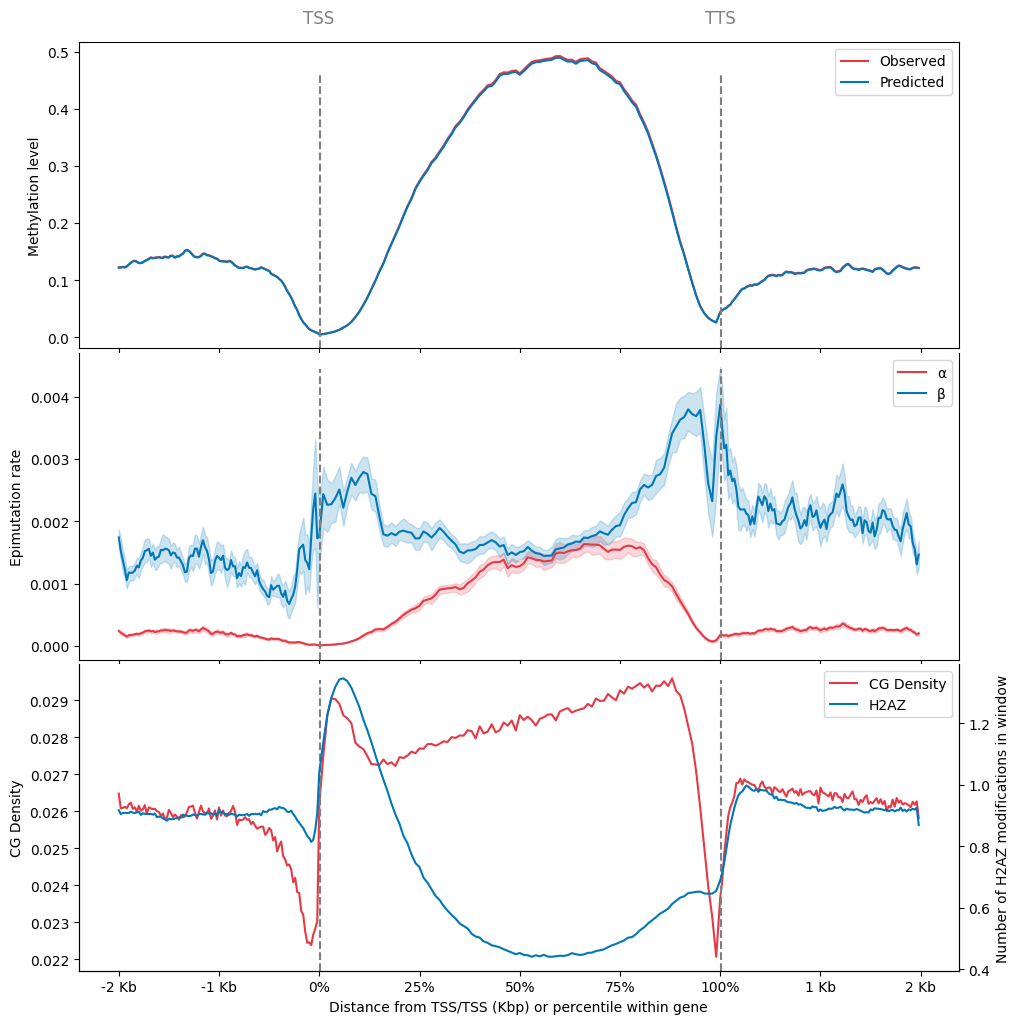

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1 ,sharex=True, figsize=(10,10)) 
ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis for H2AZ

r = "#e63946"
b = "#0077b6"

ax1.plot(x, obs, r, x, pred, b)
ax2.plot(x, alpha, r, x, beta, b)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, beta_ci_lower, beta_ci_upper, color=b, alpha=0.2)
c, = ax3.plot(x, cg_density, r, label='CG Density')
h, = ax4.plot(x, h2az, b, label='H2AZ')

def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
    
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
ax1.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-40, 0.55),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(962, 0.55),  color='C7', fontsize=12)
ax1.legend(['Observed', 'Predicted'], loc='upper right')
ax1.set_ylabel('Methylation level')



ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α', 'β'], loc='upper right')
ax2.set_ylabel("Epimutation rate")

ax3.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax3.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax3.legend([c,h],['CG Density', "H2AZ"], loc='upper right')
ax3.set_ylabel("CG Density")
ax3.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')
ax4.set_ylabel("Number of H2AZ modifications in window")


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines["top"].set_visible(False)



plt.savefig("3.png", dpi=120, bbox_inches="tight", pad_inches = 1)
plt.show()



## Fig. S1

- Comparison of wt, cmt3 and suv 

- Observed
- Alpha
- Beta

First, we need to calculate the statistical significance of the difference between each genotype for both alpha and beta. This is done by the compair function based on a t-test

In [22]:
from scipy import stats

# Samples a & b are lists of observables like alpha or beta; n is the number of samples in the pedigree
def compair(a,b, std_a, std_b,  n_a, n_b):
    
    t = (a-b) / np.sqrt( (std_a**2 + std_b**2)  )
    df = ((std_a**2 + std_b**2)**2) / ( (std_a**4 / (n_a-1)) + (std_b**4 / (n_b-1)) )
    p = stats.t.sf(np.abs(t), df)
    return p


In [80]:
wt_alphas = alpha
cmt3_alphas = cmt3[:, cmt3_headers.index("alpha")]
suv_alphas = suv[:, suv_headers.index("alpha")]

wt_betas = beta
cmt3_betas = cmt3[:,cmt3_headers.index("beta")]
suv_betas = suv[:,suv_headers.index("beta")]

wt_alpha_std = wt_new[:,wt_new_headers.index("sd_alpha")]
cmt3_alpha_std = cmt3[:,cmt3_headers.index("sd_alpha")]
suv_alpha_std = suv[:,suv_headers.index("sd_alpha")]

wt_beta_std = wt_new[:,wt_new_headers.index("sd_beta")]
cmt3_beta_std = cmt3[:,cmt3_headers.index("sd_beta")]
suv_beta_std = suv[:,suv_headers.index("sd_beta")]

def N(n):
    N = (n-1) * n/2
    return N

p_values = np.zeros((wt_alphas.shape[0], 6))

# Iterate over all windows
for w in range(0, wt_alphas.shape[0]):

    n_wt = 13
    n_cmt3 = 7
    n_suv = 15

    N_wt = N(n_wt)
    N_cmt3 = N(n_cmt3)
    N_suv = N(n_suv)

    # Calculate p-values for alpha and beta
    p_alpha_wt_cmt3 = compair(wt_alphas[w], cmt3_alphas[w], wt_alpha_std[w], cmt3_alpha_std[w], N_wt, N_cmt3)
    p_beta_wt_cmt3 = compair(wt_betas[w], cmt3_betas[w], wt_beta_std[w], cmt3_beta_std[w], N_wt, N_cmt3)

    p_alpha_wt_suv = compair(wt_alphas[w], suv_alphas[w], wt_alpha_std[w], suv_alpha_std[w], N_wt, N_suv)
    p_beta_wt_suv = compair(wt_betas[w], suv_betas[w], wt_beta_std[w], suv_beta_std[w], N_wt, N_suv)

    p_alpha_cmt3_suv = compair(cmt3_alphas[w], suv_alphas[w], cmt3_alpha_std[w], suv_alpha_std[w], N_cmt3, N_suv)
    p_beta_cmt3_suv = compair(cmt3_betas[w], suv_betas[w], cmt3_beta_std[w], suv_beta_std[w], N_cmt3, N_suv)

    # Print the results in CSV format
    p_values[w] = [p_alpha_wt_cmt3, p_beta_wt_cmt3, p_alpha_wt_suv, p_beta_wt_suv, p_alpha_cmt3_suv, p_beta_cmt3_suv]


significant = lambda x :   x < 0.05

significant_windows = significant(p_values)


    

/tmp/ipykernel_279/518395233.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
/tmp/ipykernel_279/518395233.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])


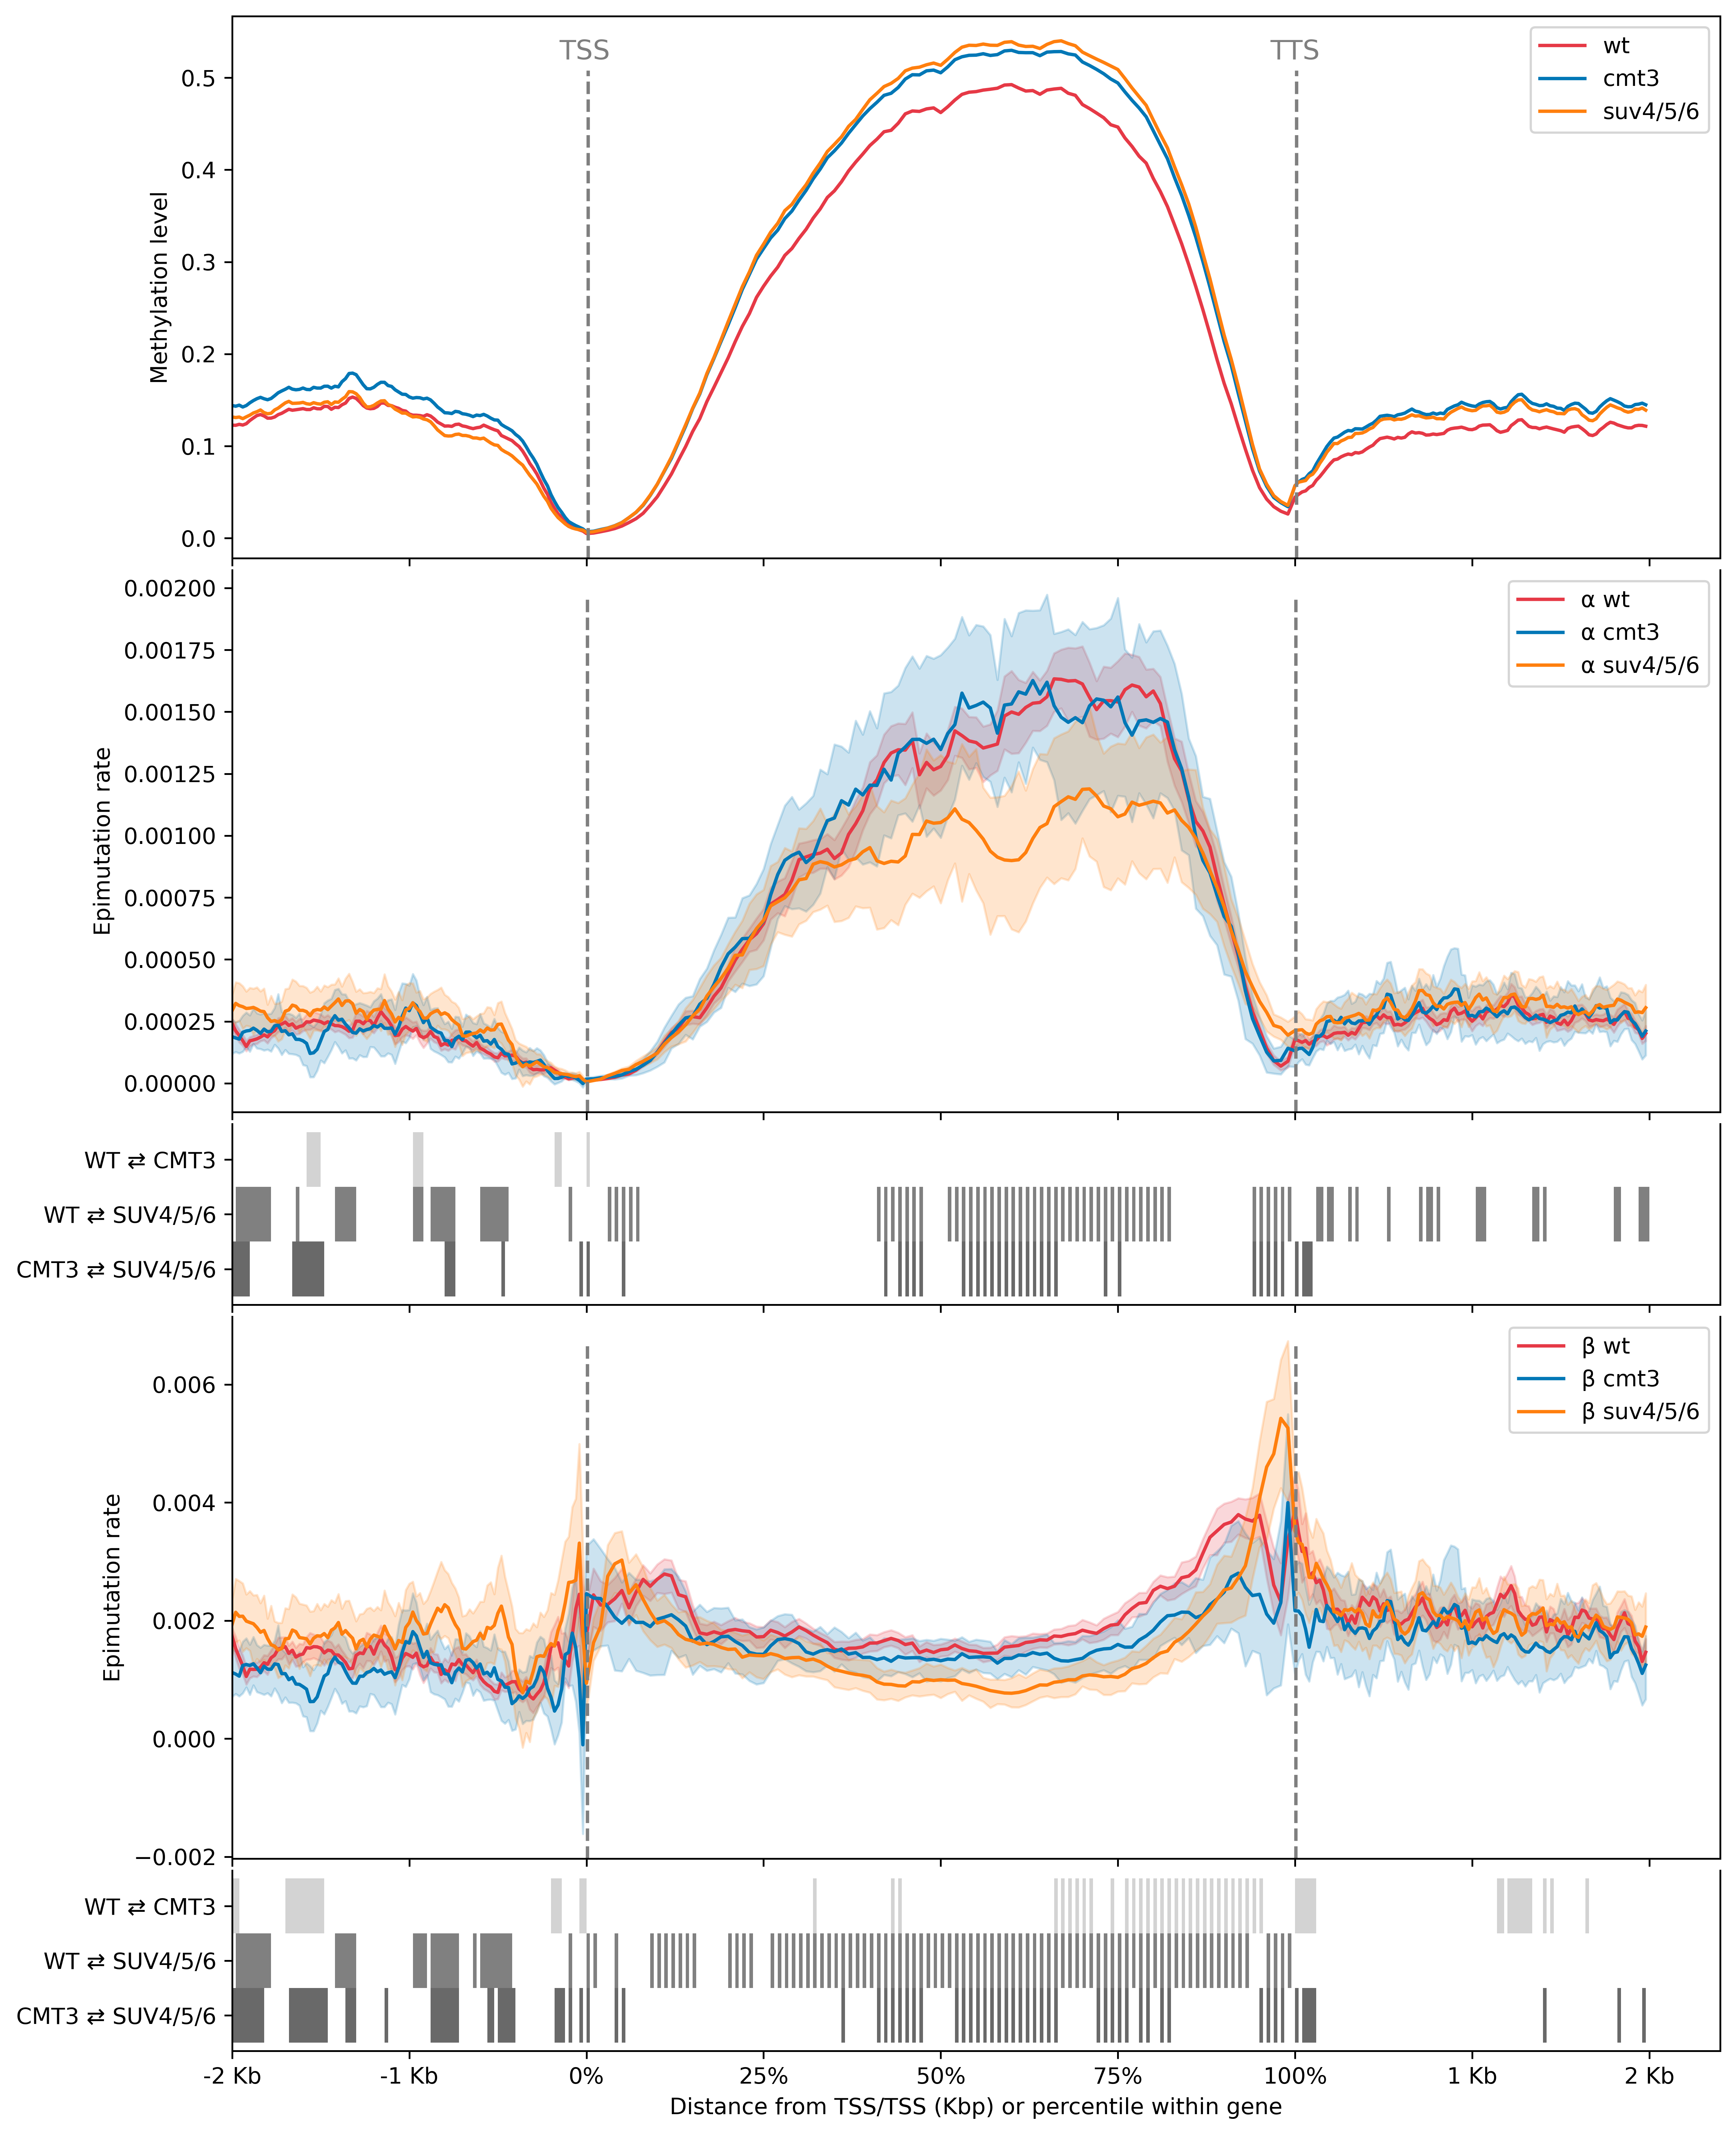

In [148]:
dpi = 450
fig, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(5,1 ,sharex=True, figsize=(10,13) ,gridspec_kw={'height_ratios': [3,3, 1,3,1]}, dpi=dpi) 



r = "#e63946"
b = "#0077b6"
o = "C1"

wt_obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
cmt_obs = cmt3[:, cmt3_headers.index('obs_steady_state')]
suv_obs = suv[:, suv_headers.index('obs_steady_state')]

cmt_alpha = cmt3[:, cmt3_headers.index('alpha')]
cmt_beta = cmt3[:, cmt3_headers.index('beta')]
cmt_alpha_ci_lower = cmt3[:, cmt3_headers.index("ci_alpha_0.025")]
cmt_alpha_ci_upper = cmt3[:, cmt3_headers.index("ci_alpha_0.975")]
cmt_beta_ci_lower = cmt3[:, cmt3_headers.index("ci_beta_0.025")]
cmt_beta_ci_upper = cmt3[:, cmt3_headers.index("ci_beta_0.975")]

suv_alpha = suv[:, suv_headers.index('alpha')]
suv_beta = suv[:, suv_headers.index('beta')]
suv_alpha_ci_lower = suv[:, suv_headers.index("ci_alpha_0.025")]
suv_alpha_ci_upper = suv[:, suv_headers.index("ci_alpha_0.975")]
suv_beta_ci_lower = suv[:, suv_headers.index("ci_beta_0.025")]
suv_beta_ci_upper = suv[:, suv_headers.index("ci_beta_0.975")]


def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    
ax1.plot(x, wt_obs, r, x, cmt_obs, b, x, suv_obs, o)
ax1.axvline(x=2,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1002, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-38, 0.52),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(965, 0.52),  color='C7', fontsize=12)
ax1.legend(['wt', 'cmt3', "suv4/5/6"], loc='upper right')
ax1.set_ylabel('Methylation level')

# Pick every second entry, then reverse the order (the barplot is kinda upside down)
significant_alphas = significant_windows[:, 0::2][:, ::-1]
significant_betas = significant_windows[:, 1::2][:, ::-1]

ax2.plot(x, alpha, r, x, cmt_alpha, b, x, suv_alpha, o)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, cmt_alpha_ci_lower, cmt_alpha_ci_upper, color=b, alpha=0.2)
ax2.fill_between(x, suv_alpha_ci_lower, suv_alpha_ci_upper, color=o, alpha=0.2)
ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α wt', 'α cmt3' , "α suv4/5/6"], loc='upper right')
ax2.set_ylabel("Epimutation rate")

label = [0,.05,.1]
colors = ["dimgray", "gray", "lightgray"]
for w in range(significant_windows.shape[0]):
    left = 0 
    if w < 100:
        left = w * 5 -500
    if w >= 100 and w < 200:
        left = (w-100) * 10
    if w >= 200:
        left = (w-200) * 5 + 1000

    
    ax3.barh(label, significant_alphas[w]*5,  color=colors, left=left, height=.05, )

ax4.plot(x, beta, r, x, cmt_beta, b, x, suv_beta, o)
ax4.fill_between(x, beta_ci_lower, beta_ci_upper, color=r, alpha=0.2)
ax4.fill_between(x, cmt_beta_ci_lower, cmt_beta_ci_upper, color=b, alpha=0.2)
ax4.fill_between(x, suv_beta_ci_lower, suv_beta_ci_upper, color=o, alpha=0.2)

ax4.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax4.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax4.legend(['β wt', "β cmt3", "β suv4/5/6"], loc='upper right')
ax4.set_ylabel("Epimutation rate")
ax5.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')


for w in range(significant_windows.shape[0]):
    left = 0 
    if w < 100:
        left = w * 5 -500
    if w >= 100 and w < 200:
        left = (w-100) * 10
    if w >= 200:
        left = (w-200) * 5 + 1000

    
    ax5.barh(label, significant_betas[w]*5,  color=colors, left=left, height=.05)


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax3.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
ax3.yaxis.set_ticks([0.0, 0.05, 0.1])


ax5.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
ax5.yaxis.set_ticks([0.0, 0.05, 0.1])

plt.savefig("4.png",  bbox_inches="tight", pad_inches = 1)
plt.show()



Figure 3 right

- $\alpha$ vs CG Density
- $\alpha$ vs H2AZ

Show dotplot and lowess line

# Fig. 3D

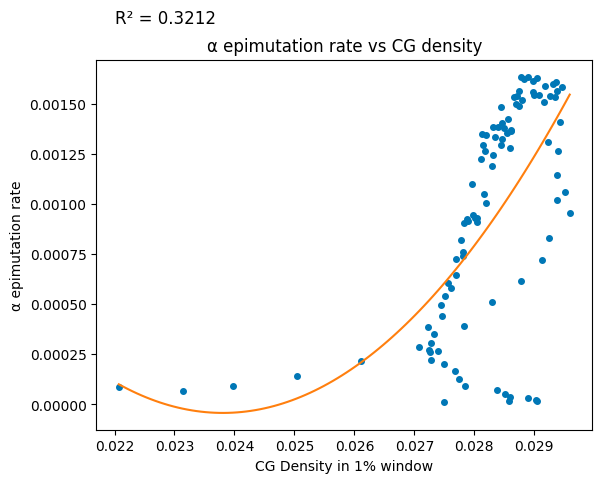

In [9]:
intragenic_cg_density = cg_density[101:200] 
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_cg_density, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_cg_density, intragenic_alpha, 2)
x = np.linspace(min(intragenic_cg_density), max(intragenic_cg_density), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs CG density")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(0.022, 0.0019, f"R² = 0.3212", fontsize=12)
plt.xlabel("CG Density in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_D.png", dpi=450, ) # TODO: alpha label not readable
plt.show()


## Fig. 3E 

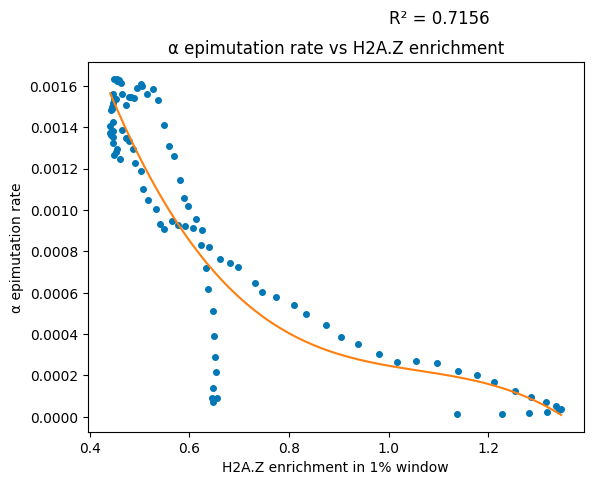

In [10]:
intragenic_h2az = h2az[101:200]
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_h2az, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_h2az, intragenic_alpha, 3)
x = np.linspace(min(intragenic_h2az), max(intragenic_h2az), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs H2A.Z enrichment")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(1, 0.0019, f"R² = 0.7156", fontsize=12)
plt.xlabel("H2A.Z enrichment in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_E.png", dpi=450) # TODO: alpha label not readable
plt.show()

# Fig. 1C 

Column Chart for Steady State

/tmp/ipykernel_279/1567519545.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(gens)


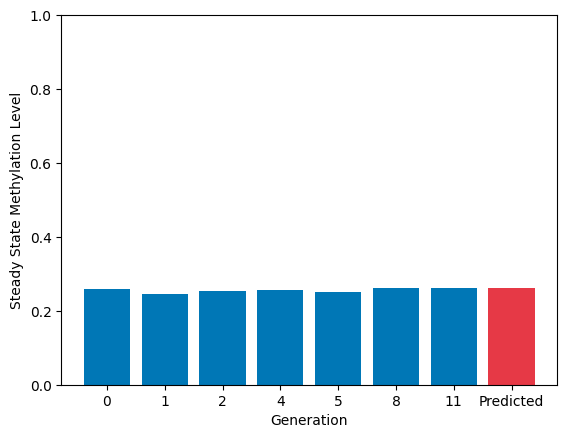

In [11]:

gens = ['', 0,1,2,4,5,8,11, "Predicted"]

# Create a figure and axes objects
fig, ax = plt.subplots()

# Create a list of colors for the columns
colors = [b] * 7 + [r] 

# Create the bar chart with custom colors
ax.bar(range(8), np.array(meth_lvl, dtype=np.float32), color=colors)

# Set the x-axis tick labels
ax.set_xticklabels(gens)
ax.set_ybound(0.0, 1.0)

# Set the title and axis labels
ax.set_xlabel('Generation')
ax.set_ylabel('Steady State Methylation Level')

# Show the plot
plt.savefig("1C.png", dpi=450)
plt.show()



## Fig. 1B

Divergence over Time

The optained Z-Score 16.00161281731142 leads to a p-value of 1.0000202970953328e-56, which rejects the Null-Hypothesis


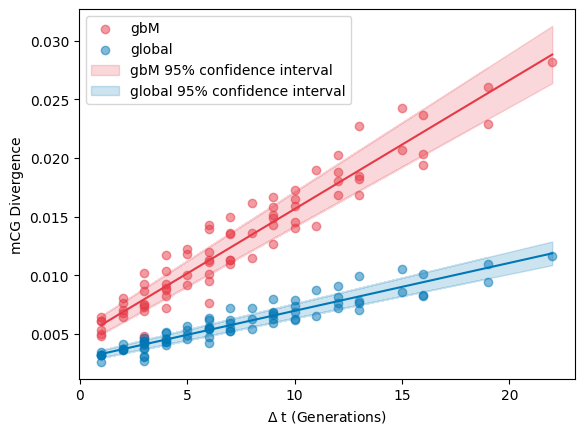

In [12]:
from scipy import stats

delta_t = D_dt[:,D_dt_headers.index("delta_t")]
D_gbM = D_dt[:,D_dt_headers.index("gbM")]
D_global = D_dt[:,D_dt_headers.index("all")]


fit_gbM = np.poly1d(np.polyfit(delta_t, D_gbM, 1))
fit_global = np.poly1d(np.polyfit(delta_t, D_global, 1))

lr_gbM = stats.linregress(delta_t, D_gbM)
lr_global = stats.linregress(delta_t, D_global)

x = np.linspace(min(delta_t), max(delta_t), num=100)

# Hypothesis test
# Nullhypthesis: slope (aka mutation rate) is the same between the two regions
# Alternative: the slope is different
# alpha < 0.05
# Using the Z-Test:  Clogg, C. C., Petkova, E., & Haritou, A. (1995). Statistical methods for comparing regression coefficients between models. American Journal of Sociology, 100(5), 1261–1293. https://doi.org/10.1086/230638
z = lambda b1, b2, stderr_b1, stderr_b2: (b1 - b2) / np.sqrt(stderr_b1**2 + stderr_b2**2)

Z = z(lr_gbM.slope, lr_global.slope, lr_gbM.stderr, lr_global.stderr)
p = stats.norm.pdf(Z)

print(f"The optained Z-Score {Z} leads to a p-value of {p}, which rejects the Null-Hypothesis")





# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
ts = abs(stats.t.ppf(0.05/2, len(D_gbM)-2))


plt.scatter(delta_t, D_gbM, color=r, alpha=0.5, label="gbM")
plt.scatter(delta_t, D_global, color=b, alpha= 0.5, label = "global")
plt.fill_between(delta_t, delta_t * (lr_gbM.slope -  ts * lr_gbM.stderr) + lr_gbM.intercept - ts*lr_gbM.intercept_stderr, delta_t * (lr_gbM.slope + ts * lr_gbM.stderr) + lr_gbM.intercept  + ts*lr_gbM.intercept_stderr, color=r, alpha=0.2, label="gbM 95% confidence interval")
plt.fill_between(delta_t, delta_t * (lr_global.slope -  ts * lr_global.stderr) + lr_global.intercept - ts*lr_global.intercept_stderr, delta_t * (lr_global.slope + ts * lr_global.stderr) + lr_global.intercept  + ts*lr_global.intercept_stderr, color=b, alpha=0.2, label="global 95% confidence interval")

plt.legend()
plt.ylabel("mCG Divergence")
plt.xlabel("$\Delta$ t (Generations)")
plt.plot(x, fit_gbM(x), color=r)
plt.plot(x, fit_global(x), color=b)
plt.savefig("1D.png", dpi=450)
plt.show()
